# Setup

In [1]:
%matplotlib inline

import numpy as np
import scipy.signal as sig
import scipy.stats as stat
import matplotlib.pyplot as plt
import seaborn as sns
import os
import h5py
import resin
import sklearn.cluster

import pandas as pd
from pandas import DataFrame,Series,read_table

from mpl_toolkits.mplot3d import Axes3D

## Saving parameters

In [2]:
birds = ['2', '2LL', '3', '3LL', '4', '4LL']

savePlots = True    # whether or not to save plots
saveData = True # whether or not to save csv files

saveAsPath = './Fig 09/'
if not os.path.exists(saveAsPath):
    os.mkdir(saveAsPath)

saveAsName = 'Fig9h_'

In [3]:
scores_path = '../formatted_scores/'

# Path to CSVs with epoch-by-epoch variables
var_path = './Epoch-by-epoch_variables/' #'../data_copies/Epoch_variables/'
events_path  = '../data_copies/SWs_EMs_and_EMartifacts/1s-epochs/'

## Paths

In [4]:
birdPaths =    ['../data_copies/01_PreprocessedData/01_BudgieFemale_green1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/00_Baseline_night/',
                '../data_copies/01_PreprocessedData/05_BudgieFemale_green2/00_Baseline_night/']

arfFilePaths =  ['EEG 2 scored/',
                 'EEG 3 scored/',
                 'EEG 3 scored/',
                 'EEG 4 scored/',
                 'EEG 4 scored/']

### load BEST EEG channels - as determined during manual scoring ####
channelsToLoadEEG_best = [['5 LEEGf-LEEGp', '6 LEEGm-LEEGp'],
                     ['5 LEEGf-LEEGm'], #, '4 LEEGf-Fgr'] this channel seems to have too much artifact
                     ['6LEEGm-LEEGp', '9REEGm-REEGp'],
                     ['9REEGf-REEGp', '6LEEGm-LEEGf'],
                     ['4LEEGf-LEEGp','7REEGf-REEGp']]


### load ALL of EEG channels ####
channelsToLoadEEG = [['4 LEEGf-Fgr', '5 LEEGf-LEEGp', '6 LEEGm-LEEGp', '7 LEEGp-Fgr', '8 REEGp-Fgr','9 REEGp-LEEGp'],
                     ['4 LEEGf-Fgr','5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '7 REEGf-Fgr', '8 REEGm-Fgr', '9 REEGf-REEGm'],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                     ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr', '8REEGf-REEGm','9REEGf-REEGp',],
                     ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp']]


channelsToLoadEOG = [['1 LEOG-Fgr', '2 REOG-Fgr'],
                     ['2 LEOG-Fgr', '3 REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr'],
                     ['2LEOG-Fgr', '3REOG-Fgr']]

birds_LL = [1,2,3]
nBirds_LL = len(birds_LL)

birdPaths_LL = ['../data_copies/01_PreprocessedData/02_BudgieMale_yellow1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/03_BudgieFemale_white1/01_Constant_light/',
                '../data_copies/01_PreprocessedData/04_BudgieMale_yellow2/01_Constant_light/',]

arfFilePaths_LL =  ['EEG 2 preprocessed/',
                    'EEG 2 preprocessed/',
                    'EEG 2 preprocessed/']

lightsOffSec = np.array([7947, 9675, 9861 + 8*3600, 9873, 13467])  # lights off times in seconds from beginning of file
lightsOnSec = np.array([46449, 48168, 48375+ 8*3600, 48381, 52005]) # Bird 3 gets 8 hours added b/c file starts at 8:00 instead of 16:00

epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','s','u'] # moving wake, quiet wake, drowsy, sleep, unclear

## Path to scores formatted as CSVs
formatted_scores_path = '../formatted_scores/'

## Path to detect SW ands EM events
events_path = '../data_copies/SWs_EMs_and_EMartifacts/1s-epochs/'

## General info

In [5]:
epochLength = 3
sr = 200
scalingFactor = (2**15)*0.195       # scaling/conversion factor from amplitude to uV (when recording arf from jrecord)

stages = ['w','d','u','i','s','r'] # wake, drowsy, unihem sleep, intermediate sleep, SWS, REM
stagesSleep =    ['u','i','s','r']

stagesVideo = ['m','q','d','l','g','s','u'] # moving wake, quiet wake, drowsy, left uni, right uni, sleep, unclear

In [6]:
# Calculate general variables
lightsOffEp = lightsOffSec / epochLength
lightsOnEp = lightsOnSec / epochLength

epochLengthPts = epochLength*sr

nStages = len(stagesSleep)

## Colors

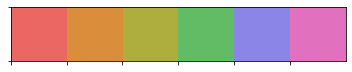

In [7]:
colors = sns.color_palette(np.array([[234,103,99],
[218,142,60],
[174,174,62],
[97,188,101],
[140,133,232],
[225,113,190]])
/255)

sns.palplot(colors)

# colorpalette from iWantHue

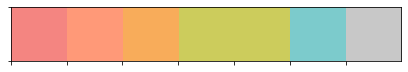

In [8]:
colors_video = sns.color_palette(np.array([[244,133,129],
                                           [255,153,120],
                                            [248,172,90],
                                            [204,204,92],
                                            [204,204,92],
                                            [124, 203, 204],
                                            [200, 200, 200]])
                                            /(255))

sns.palplot(colors_video)

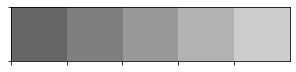

In [9]:
colors_birds = [np.repeat(.4, 3),
                np.repeat(.5, 3),
                np.repeat(.6, 3),
                np.repeat(.7, 3),
                np.repeat(.8, 3)]

sns.palplot(colors_birds)


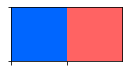

In [10]:
LD_color=[0, 102/255, 1]
LL_color=[1, 99/255, 99/255]

sns.palplot([LD_color, LL_color])

## Plot formatting

In [11]:
sns.set_context("notebook", font_scale=1.5)
sns.set_style("white")

# Markers for legends of EEG scoring colors
legendMarkersEEG = []
for stage in range(len(stages)):
    legendMarkersEEG.append(plt.Line2D([0],[0], color=colors[stage], marker='o', linestyle='', alpha=0.7)) 
    
# Markers for legends of video scoring colors
legendMarkersVideo = []
for stage in range(len(stagesVideo)):
    legendMarkersVideo.append(plt.Line2D([0],[0], color=colors_video[stage], marker='o', linestyle='', alpha=0.7))  

In [12]:
figsize = (9,10)
figsize_smaller = (6,8)
axis_label_fontsize = 24

# Dot formatting
alpha_main = 0.2
alpha_darker = 0.3


# Line formatting
linewidth = 5
linealpha = .7
marker = 'o'
markersize = 10
err_capsize = 3
err_capthick = 3
elinewidth = 3

# Bar formatting
bar_linewidth = 4

# Load data

## Scores

In [13]:
AllScores = {}
for b in birds:
    scores_file = 'All_scores_Bird {}.csv'.format(b)
    AllScores['Bird ' + b] = pd.read_table(scores_path + scores_file, sep=',', index_col=0)

## Per-epoch variables

In [14]:
SleepVariables_raw = {}

for file in os.listdir(var_path):
    if file.endswith('.csv'):
        data = pd.read_csv(var_path + file, index_col=0)
        ch = file.split('_')[0].split('.')[0]   # get name of channel from filename
        
        SleepVariables_raw[ch] = data

## Remove high-amplitude artifacts

In [15]:
channel_artifact_thres = {
    'Bird 2: 4 LEEGf-Fgr' : 504.72536588215985,
    'Bird 2: 5 LEEGf-LEEGm' : 260.6034616921849,
    'Bird 2: 6 LEEGm-LEEGp' : 248.599520730528,
    'Bird 2: 7 REEGf-Fgr' : 524.3624990659733,
    'Bird 2: 8 REEGm-Fgr' : 563.8844002322004,
    'Bird 2: 9 REEGf-REEGm': 415.4251751631489,
    'Bird 2LL: 4 LEEGf-Fgr' : 4406.433842845319,
    'Bird 2LL: 5 LEEGf-LEEGm' : 366.25538004536395,
    'Bird 2LL: 6 LEEGm-LEEGp' : 362.7644075778204,
    'Bird 2LL: 7 REEGf-Fgr' : 4384.478343375354,
    'Bird 2LL: 8 REEGm-Fgr' : 4411.889950231094,
    'Bird 2LL: 9 REEGf-REEGm' : 610.215352151259,
    'Bird 3: 4LEEGf-LEEGp' : 434.3907547931754,
    'Bird 3: 5LEEGf-LEEGm' : 570.3830657447792,
    'Bird 3: 6LEEGm-LEEGp' : 431.8025000446411,
    'Bird 3: 7REEGf-REEGp' : 682.6618564103704,
    'Bird 3: 8REEGf-REEGm' : 630.2331039533059,
    'Bird 3: 9REEGm-REEGp' : 565.1595695127436,
    'Bird 3LL: 4LEEGf-LEEGp' : 499.4068691714165,
    'Bird 3LL: 5LEEGf-LEEGm' : 542.0150907203132,
    'Bird 3LL: 6LEEGm-LEEGp' : 340.2319650694524,
    'Bird 3LL: 7REEGf-REEGp' : 320.15491558954704,
    'Bird 3LL: 8REEGf-REEGm' : 432.7719387388962,
    'Bird 3LL: 9REEGm-REEGp' : 336.2021306395864,
    'Bird 4: 4LEEGf-LEEGp' : 326.9907988688425,
    'Bird 4: 5LEEGm-LEEGp' : 229.17181995825953,
    'Bird 4: 6LEEGm-LEEGf' : 305.3846764062442,
    'Bird 4: 7REEGf-Fgr' : 236.09867154982518,
    'Bird 4: 8REEGf-REEGm' : 4358.523887351811,
    'Bird 4: 9REEGf-REEGp' : 390.99383856831656,
    'Bird 4LL: 4LEEGf-LEEGp' : 173.0596647759594,
    'Bird 4LL: 5LEEGm-LEEGp' : 170.26483511120819,
    'Bird 4LL: 7REEGf-Fgr' : 214.83376105957555,
    'Bird 4LL: 8REEGf-REEGm' : 1373.1455172252208,
    'Bird 4LL: 6LEEGm-LEEGf' : 171.49782939690607,
    'Bird 4LL: 9REEGf-REEGp' : 160.2987283133437}

In [16]:
EEGchannels = np.sort(list(channel_artifact_thres.keys()))


AllEpochs = pd.DataFrame([]) # init --> get number of epochs

nEpochs = pd.Series([])

for ch in EEGchannels:
    nEpochs.loc[ch] = len(SleepVariables_raw[ch])
        
AllEpochs['nEpochs'] = nEpochs

In [17]:
nEpochs_remaining = pd.Series([])
for ch in EEGchannels:
    ChannelVariables = SleepVariables_raw[ch].copy()
    
    # pull out only sleep rows
    sleep_data = ChannelVariables[ChannelVariables["is sleep"]==1]
    amp_thres = channel_artifact_thres[ch]
    
    # remove epochs with a max amplitude exceeding the threshold
    sleep_data = sleep_data[np.abs(sleep_data['max amp']) < amp_thres]
    
    SleepVariables_raw[ch] = sleep_data
    
    # Calc number of epochs remaining
    nEpochs_remaining.loc[ch] = len(sleep_data)
        
AllEpochs['nEpochs w/o max amp'] = nEpochs_remaining



### pull out sleep data only and z-score SleepVariables

In [18]:
dont_z_score = ['Epoch', 'sleep scores', 'video scores', 'is sleep', 'nPeaks',
               'Delta', 'DeltaLog', 'GammaDeltaRatio', 'SD', 'diffDeltaLog', 'diffGammaDeltaRatio']

channels = np.sort(list(SleepVariables_raw.keys()))
SleepVariables = {}

for ch in channels:
    b = int(ch[5]) - 1
    
    raw_data = SleepVariables_raw[ch].copy()
    
    # get sleep data only
    sleep_data = raw_data[raw_data['is sleep'] == 1] # exclude artifact, wake, drowsy, and US epochs
    
    tmp_data = sleep_data.copy()
    
    for variable in dont_z_score:
        if variable in sleep_data.columns.values:
            tmp_data = tmp_data.drop(variable, axis=1) # don't zscore these things
    
    # Zscore
    for col in tmp_data.columns.values:
        col_data = tmp_data[col]
        col_data[~np.isnan(col_data)] = stat.zscore(col_data[~np.isnan(col_data)])
        
        tmp_data[col] = col_data
        
    # Add back in non-z-scored variables e.g.g Epoch # and manual scores
    
    for variable in dont_z_score:
        if variable in sleep_data.columns.values:
            tmp_data[variable] = sleep_data[variable]

    
    SleepVariables[ch] = tmp_data
        

## calc how many epochs removed

In [19]:
EEGchannels_to_use = ['Bird 2: 5 LEEGf-LEEGm',   'Bird 2: 6 LEEGm-LEEGp',   'Bird 2: 9 REEGf-REEGm',
                      'Bird 2LL: 5 LEEGf-LEEGm', 'Bird 2LL: 6 LEEGm-LEEGp', 'Bird 2LL: 9 REEGf-REEGm',
                      'Bird 3: 4LEEGf-LEEGp',   'Bird 3: 5LEEGf-LEEGm',   'Bird 3: 6LEEGm-LEEGp',
                      'Bird 3LL: 4LEEGf-LEEGp', 'Bird 3LL: 5LEEGf-LEEGm', 'Bird 3LL: 6LEEGm-LEEGp',
                      'Bird 4: 5LEEGm-LEEGp', 'Bird 4: 6LEEGm-LEEGf', 'Bird 4: 9REEGf-REEGp',
                      'Bird 4LL: 5LEEGm-LEEGp', 'Bird 4LL: 6LEEGm-LEEGf', 'Bird 4LL: 9REEGf-REEGp']

AllEpochs_to_use = AllEpochs.loc[EEGchannels_to_use]
print('mean % epochs removed by max amp cutoff')
perc_ep_rm = 100*((AllEpochs_to_use['nEpochs'] - AllEpochs_to_use['nEpochs w/o max amp'])/AllEpochs_to_use['nEpochs'])
print(np.mean(perc_ep_rm), '%  +/-', np.std(perc_ep_rm))

mean % epochs removed by max amp cutoff
3.5787629583528764 %  +/- 2.1379415352564757


# Plot

## get channels that were good through both LD and LL

In [20]:
# LL: channels that were still good
channelsToLoadEEG_LL = [['5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '9 REEGf-REEGm'], # BIRD 2 bad ch: '4 LEEGf-Fgr', '7 REEGf-Fgr', '8 REEGm-Fgr',
                        ['4LEEGf-LEEGp', '5LEEGf-LEEGm', '6LEEGm-LEEGp', '7REEGf-REEGp', '8REEGf-REEGm', '9REEGm-REEGp'],
                        ['4LEEGf-LEEGp', '5LEEGm-LEEGp', '6LEEGm-LEEGf', '7REEGf-Fgr','9REEGf-REEGp']] # BIRD 4 bad ch: '8REEGf-REEGm'


In [21]:
variables = ["DeltaLog", "GammaDeltaRatio", 'diffDeltaLog', 'diffGammaDeltaRatio',
             "nPeaks", "SD"]

In [22]:
sns.set_palette(colors_video)

In [23]:
legendMarkers = []

color = 'b'
legendMarkers.append(plt.Line2D([0],[0], color=color, alpha=linealpha, lw=linewidth/2)) 

color = 'r'
legendMarkers.append(plt.Line2D([0],[0], color=color, alpha=linealpha, lw=linewidth/2)) 

In [24]:
BirdChannels = {}

### Bird 2

In [25]:
bird = 'Bird 2'
b = int(bird[5]) - 1
bird_channels_all = channelsToLoadEEG_LL[b - 1]
BirdChannels[bird] = bird_channels_all

### Bird 3

In [26]:
bird = 'Bird 3'
b = int(bird[5]) - 1
bird_channels_all = channelsToLoadEEG_LL[b-1]
BirdChannels[bird] = bird_channels_all[0:4] # take out channel 8 -- drastic change in quiet wake nPeaks from LD to LL
BirdChannels[bird].append(bird_channels_all[5])


### Bird 4

In [27]:
bird = 'Bird 4'
b = int(bird[5]) - 1
bird_channels_all = channelsToLoadEEG_LL[b-1]
BirdChannels[bird] = bird_channels_all


## Histograms: one variable, all birds

### nPeaks raw

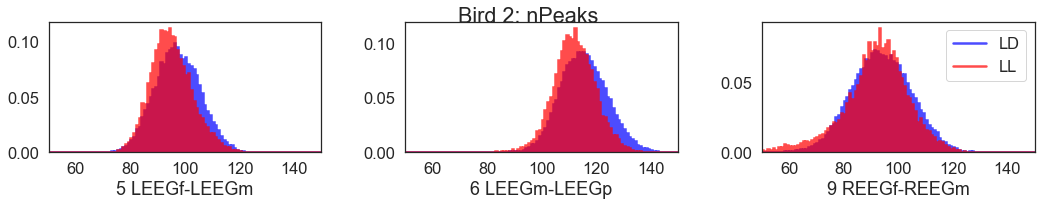

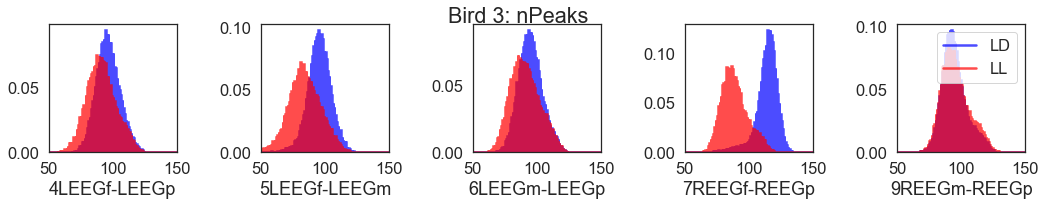

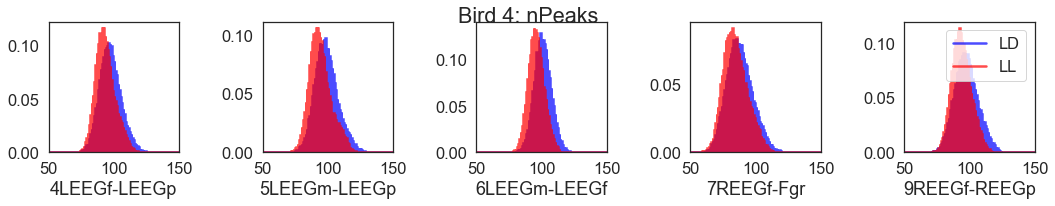

In [28]:
var = 'nPeaks'
x_range = (50, 150)

for bird in ['Bird 2', 'Bird 3', 'Bird 4']:
    b = int(bird[5]) - 1
    bird_channels_all = channelsToLoadEEG[b]
    bird_channels = BirdChannels[bird]

    plt.figure(figsize=(15,3))

    for n, ch_name in enumerate(bird_channels):
        plt.subplot(1, len(bird_channels), n+1)

        for LDorLL in ['', 'LL']:

            ch_to_plot = bird + LDorLL + ': ' + ch_name

            ch_variables = SleepVariables[ch_to_plot]
            ch_variables_sleep = ch_variables[ch_variables['is sleep']==1]

            if LDorLL == 'LL':
                color = 'r'
            else:
                color = 'b'

            plt.hist(ch_variables[var], color=color, density=True, bins=200,
                     histtype='step', lw=linewidth/2, alpha=linealpha,
                     range=x_range)

            plt.xlabel(ch_name)
            plt.xlim(x_range)
            #plt.ylim(0,2)

    plt.legend(legendMarkers,['LD','LL'])

    plt.suptitle(bird + ": " + var)
    plt.tight_layout()
    plt.savefig(saveAsPath + saveAsName + var + '_histograms.pdf')


#### plot bar graph

Bird 2
Ttest_relResult(statistic=5.498242791822666, pvalue=0.03152320094905814)
Bird 3
Ttest_relResult(statistic=2.038948435790124, pvalue=0.11107632572863574)
Bird 4
Ttest_relResult(statistic=12.403875191224182, pvalue=0.00024284770757580887)


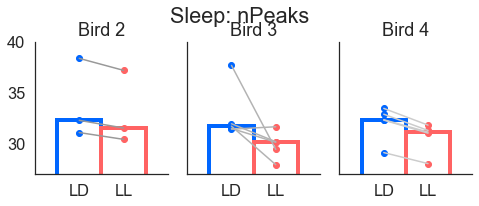

In [29]:
var = 'nPeaks'
y_range = ([27,40], [27,40], [27,40])
plt.figure(figsize=(7,3))

All_LD_means = {}
All_LL_means = {}

for bird in ['Bird 2', 'Bird 3', 'Bird 4']:
    b = int(bird[5]) - 1
    bird_channels_all = channelsToLoadEEG[b]
    bird_channels = BirdChannels[bird]
    plt.subplot(1, len(birds_LL), b)

    bird_LD_means = []
    bird_LL_means = []
    for n, ch_name in enumerate(bird_channels):
        

        for LDorLL in ['', 'LL']:

            ch_to_plot = bird + LDorLL + ': ' + ch_name

            ch_variables = SleepVariables[ch_to_plot]
            ch_variables_sleep = ch_variables[ch_variables['is sleep']==1]

            if LDorLL == 'LL':
                color = LL_color
                x_pos = 1
                LL_mean = np.nanmean(ch_variables[var])/epochLength
                bird_LL_means.append(LL_mean)
            else:
                color = LD_color
                x_pos = 0
                LD_mean = np.nanmean(ch_variables[var])/epochLength
                bird_LD_means.append(LD_mean)

            plt.scatter(x_pos, np.nanmean(ch_variables[var])/epochLength, color=color)
            
        # line plot
        plt.plot([0, 1], [LD_mean, LL_mean], color=colors_birds[b+1])

    # bar plot of MEDIAN across channels
    plt.bar([0, 1], [np.median(bird_LD_means), np.median(bird_LL_means)], 
            width=1, color='none', edgecolor=[LD_color, LL_color], linewidth=4)
    
    #plt.legend(legendMarkers,['LD','LL'])
    plt.xticks([0, 1], ['LD', 'LL'])

    if b !=1:
        plt.yticks([])
    plt.xlim(-1, 2)
        
    plt.ylim(y_range[b-1])
    sns.despine()

    plt.title(bird)
    
    print(bird)
    print(stat.ttest_rel(bird_LD_means, bird_LL_means))
    All_LD_means[bird] = bird_LD_means
    All_LL_means[bird] = bird_LL_means
    
plt.suptitle("Sleep: " + var)
plt.tight_layout()
#plt.savefig(saveAsPath + saveAsName + var + '_barplots.pdf')


In [30]:
All_LD_means

{'Bird 2': [32.290305825646136, 38.36363824803598, 31.09154275577816],
 'Bird 3': [31.955381392100566,
  31.71586948269317,
  31.497486615366075,
  37.67382211621556,
  31.42475625993214],
 'Bird 4': [32.3115919876554,
  32.89021288380669,
  33.46163043319773,
  29.12864622288706,
  32.34846750044037]}

In [31]:
channelsToLoadEEG_LL

[['5 LEEGf-LEEGm', '6 LEEGm-LEEGp', '9 REEGf-REEGm'],
 ['4LEEGf-LEEGp',
  '5LEEGf-LEEGm',
  '6LEEGm-LEEGp',
  '7REEGf-REEGp',
  '8REEGf-REEGm',
  '9REEGm-REEGp'],
 ['4LEEGf-LEEGp',
  '5LEEGm-LEEGp',
  '6LEEGm-LEEGf',
  '7REEGf-Fgr',
  '9REEGf-REEGp']]

In [32]:
All_LL_means

{'Bird 2': [31.539005933910392, 37.19030184687983, 30.426347697853515],
 'Bird 3': [30.193123640348727,
  27.940300940643287,
  30.140305644102757,
  29.44095139930035,
  31.659985288709084],
 'Bird 4': [31.03718609143593,
  31.299216984927735,
  31.820523031992565,
  28.048691905201597,
  31.137252442911635]}

#### Collate each ch separately

In [33]:
all_ch_means = pd.DataFrame([])
for bird in All_LD_means.keys():
    tmp = pd.DataFrame(All_LD_means[bird], columns=['value'])
    tmp['Light'] = 'LD'
    tmp['Bird'] = bird[5]
    tmp['Channel'] = BirdChannels[bird]
    all_ch_means = all_ch_means.append(tmp, sort=False)
    
for bird in All_LD_means.keys():
    tmp = pd.DataFrame(All_LL_means[bird], columns=['value'])
    tmp['Light'] = 'LL'
    tmp['Bird'] = bird[5]
    tmp['Channel'] = BirdChannels[bird]
    all_ch_means = all_ch_means.append(tmp)

## FIGURE 9H

#### plot bar graph w/ mean line

In [34]:
LD_grandmean = []
LL_grandmean = []
for bird in All_LD_means.keys():
    LD_grandmean.append(np.median(All_LD_means[bird])) # MEDIAN
    LL_grandmean.append(np.median(All_LL_means[bird]))

Bird 2
Ttest_relResult(statistic=5.498242791822666, pvalue=0.03152320094905814)
Bird 3
Ttest_relResult(statistic=2.038948435790124, pvalue=0.11107632572863574)
Bird 4
Ttest_relResult(statistic=12.403875191224182, pvalue=0.00024284770757580887)


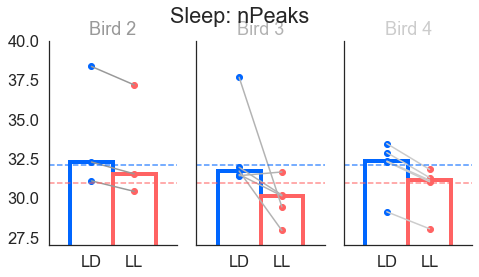

In [35]:
var = 'nPeaks'
y_range = ([27,40], [27,40], [27,40])
plt.figure(figsize=(7,4))

All_LD_means = {}
All_LL_means = {}

for bird in ['Bird 2', 'Bird 3', 'Bird 4']:
    b = int(bird[5]) - 1
    bird_channels_all = channelsToLoadEEG[b]
    bird_channels = BirdChannels[bird]
    plt.subplot(1, len(birds_LL), b)

    bird_LD_means = []
    bird_LL_means = []
    for n, ch_name in enumerate(bird_channels):
        

        for LDorLL in ['', 'LL']:

            ch_to_plot = bird + LDorLL + ': ' + ch_name

            ch_variables = SleepVariables[ch_to_plot]
            ch_variables_sleep = ch_variables[ch_variables['is sleep']==1]

            if LDorLL == 'LL':
                color = LL_color
                x_pos = 1
                LL_mean = np.nanmean(ch_variables[var])/epochLength
                bird_LL_means.append(LL_mean)
            else:
                color = LD_color
                x_pos = 0
                LD_mean = np.nanmean(ch_variables[var])/epochLength
                bird_LD_means.append(LD_mean)

            plt.scatter(x_pos, np.nanmean(ch_variables[var])/epochLength, color=color)
            
        # line plot
        plt.plot([0, 1], [LD_mean, LL_mean], color=colors_birds[b+1])

    # bar plot of MEDIAN across channels
    plt.bar([0, 1], [np.median(bird_LD_means), np.median(bird_LL_means)], 
            width=1, color='none', edgecolor=[LD_color, LL_color], linewidth=4)
    
    #plt.legend(legendMarkers,['LD','LL'])
    plt.xticks([0, 1], ['LD', 'LL'])

    if b !=1:
        plt.yticks([])
    plt.xlim(-1, 2)
        
    plt.ylim(y_range[b-1])
    sns.despine()

    plt.title(bird, color=colors_birds[b+1])
    
    print(bird)
    print(stat.ttest_rel(bird_LD_means, bird_LL_means))
    All_LD_means[bird] = bird_LD_means
    All_LL_means[bird] = bird_LL_means
    
    plt.axhline(np.mean(LD_grandmean), linestyle='--', color=LD_color, alpha=.7)
    plt.axhline(np.mean(LL_grandmean), linestyle='--', color=LL_color, alpha=.7)
    
plt.suptitle("Sleep: " + var)
plt.tight_layout()

if savePlots:
    plt.savefig(saveAsPath + saveAsName + var + '_barplots.pdf')


## save to csv

In [36]:
if saveData:
    all_ch_means.to_csv(saveAsPath + saveAsName + var + '_sleep.csv')

## ANOVAs - median of each bird

In [37]:
all_means = pd.DataFrame(np.append(LD_grandmean, LL_grandmean), columns=['value'])
all_means['State'] = 's'
all_means['Light'] = ['LD', 'LD', 'LD', 'LL', 'LL', 'LL']
all_means['Bird'] = [2, 3, 4, 2, 3, 4]

In [38]:
# Quiet wake values -- LD
tmp = pd.DataFrame([32.50367946253874, 32.60616329556285, 33.75741478530323], columns=['value']) # medians
tmp['State'] = 'q'
tmp['Light'] = 'LD'
tmp['Bird'] = [2, 3, 4]
all_means = all_means.append(tmp, sort=False)

In [39]:
# Quiet wake values -- LL
tmp = pd.DataFrame([33.188392050587176, 32.303570894964885, 33.664621228723796], columns=['value']) # medians
tmp['State'] = 'q'
tmp['Light'] = 'LL'
tmp['Bird'] = [2, 3, 4]
all_means = all_means.append(tmp, sort=False)
all_means

,value,State,Light,Bird
0,32.290306,s,LD,2
1,31.715869,s,LD,3
2,32.348468,s,LD,4
3,31.539006,s,LL,2
4,30.140306,s,LL,3
5,31.137252,s,LL,4
0,32.503679,q,LD,2
1,32.606163,q,LD,3
2,33.757415,q,LD,4
0,33.188392,q,LL,2


In [40]:
# randomized measures ANOVA
from statsmodels.stats.anova import AnovaRM

model = AnovaRM(all_means, 'value', 'Bird', within=['Light', 'State'])
anova_table = model.fit()

print(anova_table)

                  Anova
            F Value  Num DF Den DF Pr > F
-----------------------------------------
Light         4.1047 1.0000 2.0000 0.1800
State        24.1251 1.0000 2.0000 0.0390
Light:State 193.6011 1.0000 2.0000 0.0051



In [41]:
# Sleep: LL vs LD
means1 = all_means[(all_means['State']=='s')&(all_means['Light']=='LL')]
means2 = all_means[(all_means['State']=='s')&(all_means['Light']=='LD')]
stat.ttest_rel(means1['value'], means2['value'])

Ttest_relResult(statistic=-4.945380839318821, pvalue=0.03854014955688214)

In [42]:
# Wake: LL vs LD
means1 = all_means[(all_means['State']=='q')&(all_means['Light']=='LL')]
means2 = all_means[(all_means['State']=='q')&(all_means['Light']=='LD')]
stat.ttest_rel(means1['value'], means2['value'])

Ttest_relResult(statistic=0.3211468590891247, pvalue=0.7785528619529751)

In [44]:
# LL vs LD overall
means1 = all_means[(all_means['Light']=='LL')]
means2 = all_means[(all_means['Light']=='LD')]
stat.ttest_rel(means1['value'], means2['value'])

Ttest_relResult(statistic=-1.626695637860787, pvalue=0.164730281893125)

In [43]:
# All wake vs all sleep
means1 = all_means[(all_means['State']=='q')]
means2 = all_means[(all_means['State']=='s')]
stat.ttest_rel(means1['value'], means2['value'])

Ttest_relResult(statistic=4.289391208684602, pvalue=0.007793580321724434)